In [24]:
%matplotlib inline

In [25]:
path = "data/dogscats/sample/"

In [26]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [110]:
import utils; reload(utils)
from utils import plots

In [28]:
from numpy.random import random
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [29]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [30]:
pwd

u'/home/ubuntu/courses/deeplearning1/nbs'

In [31]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [32]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [33]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [34]:
def VGG_YVES():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [35]:
model = VGG_YVES()

In [36]:
    def predict(self, imgs, details=False):
        all_preds = self.model.predict(imgs)
        idxs = np.argmax(all_preds, axis=1)
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes

In [37]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [92]:
batch_size = 10

In [80]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


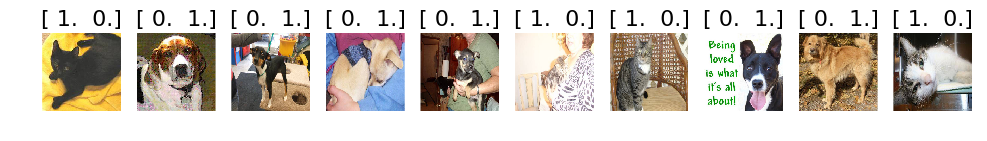

In [93]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

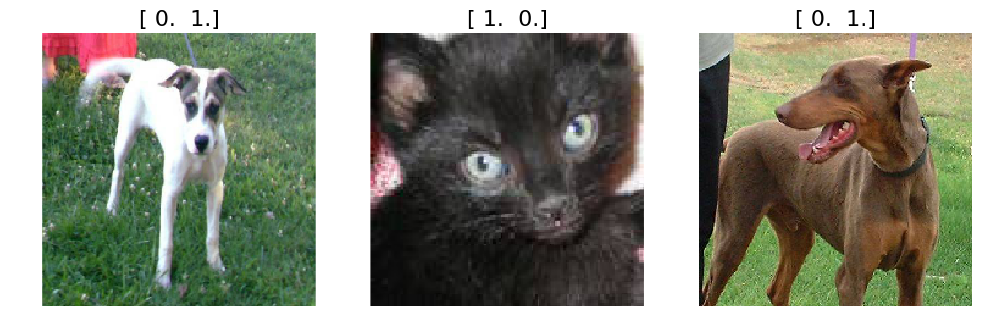

In [88]:
imgs,labels = next(batches)
plots(imgs, titles=labels)


In [101]:
    preds = model.predict(imgs)
    idxs = np.argsort(-preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    current_picture = 1
    
    for i in range(20):
        idx = idxs[current_picture,i]
        print ('  {:.4f}/{}'.format(preds[current_picture, idx], classes[idx]))

Shape: (10, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.0050e-07   3.2772e-07   2.9292e-07   2.2208e-07   4.7072e-06]

Predictions prob/class: 
  0.7524/Saint_Bernard
  0.0942/Walker_hound
  0.0469/English_foxhound
  0.0468/basset
  0.0140/beagle
  0.0136/Greater_Swiss_Mountain_dog
  0.0068/Welsh_springer_spaniel
  0.0068/Brittany_spaniel
  0.0042/bloodhound
  0.0025/boxer
  0.0022/clumber
  0.0011/Chesapeake_Bay_retriever
  0.0010/Sussex_spaniel
  0.0008/English_setter
  0.0006/Blenheim_spaniel
  0.0006/Labrador_retriever
  0.0005/English_springer
  0.0004/cocker_spaniel
  0.0004/bluetick
  0.0004/dalmatian


In [99]:
idxs.shape

(10, 1000)

In [90]:
import sklearn 
from sklearn.metrics import pairwise 

In [102]:
pairwise.pairwise_distances(preds)

array([[ 0.    ,  1.1992,  0.9838,  1.0299,  1.2701,  1.1045,  1.1017,  1.1058,  0.9587,  0.9717],
       [ 1.1992,  0.    ,  0.8201,  0.8862,  1.1555,  0.9703,  0.9677,  0.9727,  0.804 ,  0.8162],
       [ 0.9838,  0.8201,  0.    ,  0.5608,  0.9299,  0.6868,  0.6831,  0.6641,  0.4227,  0.4432],
       [ 1.0299,  0.8862,  0.5608,  0.    ,  0.9766,  0.7529,  0.7488,  0.747 ,  0.5146,  0.5408],
       [ 1.2701,  1.1555,  0.9299,  0.9766,  0.    ,  1.057 ,  1.0544,  1.0559,  0.8963,  0.9173],
       [ 1.1045,  0.9703,  0.6868,  0.7529,  1.057 ,  0.    ,  0.8446,  0.8531,  0.6574,  0.6685],
       [ 1.1017,  0.9677,  0.6831,  0.7488,  1.0544,  0.8446,  0.    ,  0.8502,  0.6533,  0.5277],
       [ 1.1058,  0.9727,  0.6641,  0.747 ,  1.0559,  0.8531,  0.8502,  0.    ,  0.6575,  0.6727],
       [ 0.9587,  0.804 ,  0.4227,  0.5146,  0.8963,  0.6574,  0.6533,  0.6575,  0.    ,  0.3952],
       [ 0.9717,  0.8162,  0.4432,  0.5408,  0.9173,  0.6685,  0.5277,  0.6727,  0.3952,  0.    ]], dtype=flo

In [125]:
# for i in range(layers):
encoded_images = model.predict(imgs)
distance_matrix = pairwise.pairwise_distances(encoded_images)
distance_matrix
#plot_confusion_matrix(distance_matrix, classes, normalize=False, title='Distance matrix', cmap=plt.cm.Blues)    

array([[ 0.    ,  1.1992,  0.9838,  1.0299,  1.2701,  1.1045,  1.1017,  1.1058,  0.9587,  0.9717],
       [ 1.1992,  0.    ,  0.8201,  0.8862,  1.1555,  0.9703,  0.9677,  0.9727,  0.804 ,  0.8162],
       [ 0.9838,  0.8201,  0.    ,  0.5608,  0.9299,  0.6868,  0.6831,  0.6641,  0.4227,  0.4432],
       [ 1.0299,  0.8862,  0.5608,  0.    ,  0.9766,  0.7529,  0.7488,  0.747 ,  0.5146,  0.5408],
       [ 1.2701,  1.1555,  0.9299,  0.9766,  0.    ,  1.057 ,  1.0544,  1.0559,  0.8963,  0.9173],
       [ 1.1045,  0.9703,  0.6868,  0.7529,  1.057 ,  0.    ,  0.8446,  0.8531,  0.6574,  0.6685],
       [ 1.1017,  0.9677,  0.6831,  0.7488,  1.0544,  0.8446,  0.    ,  0.8502,  0.6533,  0.5277],
       [ 1.1058,  0.9727,  0.6641,  0.747 ,  1.0559,  0.8531,  0.8502,  0.    ,  0.6575,  0.6727],
       [ 0.9587,  0.804 ,  0.4227,  0.5146,  0.8963,  0.6574,  0.6533,  0.6575,  0.    ,  0.3952],
       [ 0.9717,  0.8162,  0.4432,  0.5408,  0.9173,  0.6685,  0.5277,  0.6727,  0.3952,  0.    ]], dtype=flo

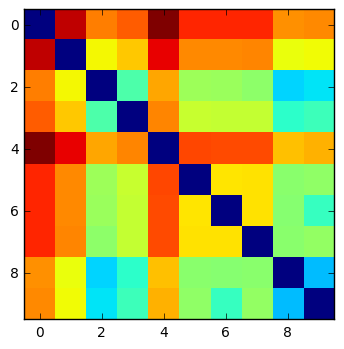

In [126]:
plt.imshow(distance_matrix, interpolation='nearest')

In [123]:
model.pop()

In [127]:
encoded_images.shape

(10, 1000)

In [119]:
model.layers